In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Set preallocation MEM
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".75"

# Deallocate memory that is no longer needed
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]
from PlaceDB import PlaceDB
from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil
import os.path
import sys
import time
import math
import pickle
import scipy.io as io
from scipy import sparse as sp
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
#import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers, sparse
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

# Restart kernal to apply GPU or CPU
PLATFORM = 'gpu'

# Check if GPU is enabled
jax.config.update('jax_platform_name', PLATFORM)
y = jax.device_put(np.arange(5), device=jax.devices(PLATFORM)[0])
print(y.device_buffer.device())
print(jax.default_backend())

/home/yuw/anaconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


gpu:0
gpu


In [4]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [5]:
import utils
from utils import *
from optimizers import *

In [6]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = '3elt'
assert graphpostfix in graphs
grid_testcase = nx.grid_graph(dim=(50, 50))
#grid_testcase = nx.triangular_lattice_graph(25,25)
#grid_testcase = nx.cycle_graph(100)
grid_testcase_adjacency = nx.adjacency_matrix(grid_testcase).toarray().astype(np.int16)
DEBUG=True
if DEBUG:
    graph, ___, ___, L, ___, n = load_graph(graphdir+graphpostfix, A=grid_testcase_adjacency, plot_adjacency=False, verbose=True)
else:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=None, plot_adjacency=False, verbose=True)

VLSI=False
if VLSI:
    edgeweight, edges, num_nodes_total, num_movable_nodes, num_nodes = utils.VLSI_import(dname='adaptec1', file_dir='VLSI_testcases/')
    A = sp.csr_matrix((edgeweight, (edges[0], edges[1])), shape=(num_nodes_total+1, num_nodes_total+1))
    D = sp.diags(np.array(A.sum(1)).flatten())
    L = D - A
    n = L.shape[0]


Graph with 2500 nodes and 4900 edges


In [7]:
# del G
# del A
# del D
print(type(L))
print(type(graph))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>


In [8]:
#@jit
def project(X1, C, E_0, c=jnp.array([0,0])):
    C1 = X1.T@X1
    print('C1 type:\n',type(C1))
    print('C1 value:\n',C1)
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,__,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt
    
    # negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)
    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = X@(-U_E@V_E.T)
    """
    negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)

    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = jax.lax.cond(negdef,
                     lambda _ : -X@(U_E@V_E.T),
                     lambda _ : X,
                     operand=None
                    )
    negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)
    """
    return X

@partial(jit, static_argnums=(3,))
def step(i, opt_state, Z, opt_update):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def _D_Z(X, A, d, e):
    I = jnp.eye(A.shape[0])
    Ad = A + d*I
    
    Del = jnp.linalg.solve(X.T@jnp.linalg.solve(Ad, X), X.T)@jnp.linalg.solve(Ad, e)
    Z = jnp.linalg.solve(Ad, -X@Del + e)
    
    return Del, Z

def Adpsolve(A, b, M=None, **kwargs):
    """ Solver for linear system As@x = b
    Args:
        b: result of the matrix system
        **kwargs: take an arbitrary number of keyword arguments
    Returns:
        solution x of the matrix system As@x = b
    """     
    # print('Adpsolve')                    
    return jax.scipy.sparse.linalg.cg(A, b, M=M, **kwargs)[0]

'''
    A: <class 'jax.experimental.sparse.bcoo.BCOO'>
    P: <class 'NoneType'>
    d: <class 'jaxlib.xla_extension.DeviceArray'>
    e: <class 'jaxlib.xla_extension.DeviceArray'>
    I: <class 'jax.experimental.sparse.bcoo.BCOO'>
    Ad: <class 'scipy.sparse.csc.csc_matrix'>
'''
# TODO convert to JAX
#@jit
def _scipy_D_Z(X, A, P, d, e, I):
    # print("inside scipy_D_Z")
    # print('A:', type(A))
    # print('P:', type(P))
    # print('d:', type(d))
    # print('e:', type(e))
    # print('I:', type(I))
    Ad = A + d*I
    # print('Ad:', type(Ad))

    # linear operator must be either a function or ndarray
    _matvec = lambda x: Ad@x                                                                # Jax version of As/sparse matrix
    matvec = jit(_matvec)

    Del = jnp.linalg.solve(X.T@(Adpsolve(matvec,X)),X.T)@Adpsolve(matvec,e)
    # Del = jnp.linalg.solve(X.T@(jnp.linalg.solve(Ad,X)),X.T)@jnp.linalg.solve(Ad,e)
    # print('Del:', type(Del))
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    XDE = (-X@Del + e)

    PXDE = XDE - (XDE@v_s)@v_s.T
    ADinvP = Adpsolve(matvec, PXDE)
    Z = ADinvP - v_s@(v_s.T@ADinvP)
    
    return Del, Z

def scipy_D_Z(X, A, P, d, e, I):
    Ad = A + d*I
    Ad = sp.csc_matrix((A.data, (A.indices[:,0], A.indices[:,1])))
        
    sp_solve = lambda A, b:jnp.array(sp.linalg.spsolve(A.astype(np.float64),b.astype(np.float64)))
   
    Del = jnp.linalg.solve(X.T@(sp_solve(Ad,X)),X.T)@sp_solve(Ad,e)
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    XDE = (-X@Del + e)

    PXDE = XDE - (XDE@v_s)@v_s.T
    ADinvP = sp_solve(Ad, PXDE)
    Z = ADinvP - v_s@(v_s.T@ADinvP)
    
    return Del, Z

 # Inside newton's method
# Compute A
#@jit
def _sqp(A, L, E_0, X):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvalsh(L)

    idx = w.argsort() 
    w = w[idx]
    E = -E_0 - (A@X + X@L)

    Del_0, Z_0 = _D_Z(X, A, w[0], E[:,0])
    Del_1, Z_1 = _D_Z(X, A, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    return Z, Del  

# Inside ssm method
# Compute PAP
#@jit
def scipy_sqp(X, A, P, L, E_0, I):
    """Perform an iteration of SQP."""
    w = jnp.linalg.eigvalsh(L)
    idx = w.argsort()  
    w = w[idx]
    v = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    v = jnp.array(v)
    # print('v:', type(v))

    AX = A@(X - v@(v.T@X))
    # print('AX:', type(AX))

    AX = AX - v@(v.T@AX)
    # print('AX:', type(AX))

    E = -E_0 - (AX + X@L)
    # print('E:', type(E))

    # Del_0, Z_0 = _scipy_D_Z(X, A, P, w[0], E[:,0], I)
    # Del_1, Z_1 = _scipy_D_Z(X, A, P, w[1], E[:,1], I)
    Del_0, Z_0 = scipy_D_Z(X, A, P, w[0], E[:,0], I)
    Del_1, Z_1 = scipy_D_Z(X, A, P, w[1], E[:,1], I)
    # print('Del_0:', type(Del_0))
    # print('Del_1:', type(Del_1))
    # print('Z_0:', type(Z_0))
    # print('Z_1:', type(Z_1))
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del  

# TODO alpha never used?
def newton(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9, initL=True):
    """Perform iterations of PND + backtracking line search."""    
    method_time = time.time()
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = np.stack([b_x, b_y], axis=1)
   
    pAp = P@A@P.T
    
    if initL:
        L = L_init(X_k, C, pAp, E_0)


    #_g = jnp.linalg.norm(g(X_k, jnp.ones((X_k.shape[0],1))/jnp.sqrt(X_k.shape[0]), c=jnp.array([0,0])))
    #_h = jnp.linalg.norm(h(X_k, jnp.eye(X_k.shape[0]), C[0,0], C[0,1], C[1,1], c=jnp.array([0,0])))
    
    report = {'x':None, 'lossh':[f(X_k, pAp, pAp, b_x, b_y)[1].item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_sqp(X_k, L, C, pAp, E_0).item()], 'step_sizes':[1], 'L':[L]}
    
    cc = 0

    def line_search(step_size):
        optt = step(step_size, opt_state, -Z, opt_update)
        xkt = get_params(optt)
        res, t = f(xkt, pAp, pAp, b_x, b_y)
        return res
    
    for k in tqdm(range(maxiters)):
        METHOD_ALT = True
        if METHOD_ALT:
            # Vectorization         
            #Z, Del = sqp(A, P, pAp, L, E_0, X_k)
            Z, Del = _sqp(pAp, L, E_0, X_k)
            
            # backtracking line search
            f_xp = jnp.finfo(jnp.float32).max
            #f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
            f_x = f(X_k, pAp, pAp, b_x, b_y)[0]
            len_p = jnp.linalg.norm(Z)
            X_k_t = X_k
            
            opt_state_t = opt_state

            # print("*************************RECORDING STEPS*************************")

            """
            1. write a function g(s_k) : s_k (step size) --> f(x, z, s_k)
            2. [s_k^0, s_k^1, s_k^2,..] \in (0,1)
            3. vmap g over []
            """
            # method 1 no for loop
            # method_time = time.time()
            # prevent neg dimension
            # TODO better way to set n?
            n = abs((math.log(1e-10) - math.log(len_p))/math.log(beta))
            # n = 100
            if math.isnan(n):
                n = 1
                s_k = np.zeros((n,1))
                for i in range(n):
                    s_k[i, :] = math.pow(beta, i+1)
                # jax numpy array s_k
                s_k = jnp.array(s_k)
                vectorize = jax.vmap(line_search, in_axes=0, out_axes=0)
                sk_to_fxp = vectorize(s_k)
                idx = 0
                _stp = s_k[idx][0]
            else:
                n = math.ceil(n)
                s_k = np.zeros((n,1))
                for i in range(n):
                    s_k[i, :] = math.pow(beta, i+1)
                # jax numpy array s_k
                s_k = jnp.array(s_k)
                vectorize = jax.vmap(line_search, in_axes=0, out_axes=0)
                sk_to_fxp = vectorize(s_k)
                idx = (sk_to_fxp < f_x).argmax()
                _stp = s_k[idx][0]
            # opt state t can be set outside for loop
            opt_state_t = step(_stp, opt_state, -Z, opt_update)
            # print("method 1 --- %s seconds ---" % (time.time() - method_time))
            # print("stp found:\n", _stp)
            # print("sk_to_fxp:\n", sk_to_fxp)

            L = L + _stp*Del
            
            foc = foc_sqp(X_k, L, C, pAp, E_0)
            # TODO how to return opt_state_t, X_k
            opt_state = opt_state_t
            X_k = get_params(opt_state_t)
            
            report['sln_path'].append(np.asarray(X_k))
            report['step_sizes'].append(_stp)
            report['foc'].append(foc.item())
            # TODO confirm this is ok?
            report['lossh'].append(sk_to_fxp[idx])
            report['L'].append(np.asarray(L))   

            if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
                cc += 1
                if cc > 10:
                    print('converged')
                    break
            if cc > 0:
                cc -= 1
        else:
            # OG method
            Z, Del = _sqp(pAp, L, E_0, X_k)
        
            # backtracking line search
            f_xp = jnp.finfo(jnp.float32).max
            stp = 1
            #f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
            f_x = f(X_k, pAp, pAp, b_x, b_y)[0]
            len_p = jnp.linalg.norm(Z)
            X_k_t = X_k
            
            opt_state_t = opt_state
            
            # TODO sometimes loop never started
            t = f_x

            while f_xp >= f_x:
                stp *= beta
                opt_state_t = step(stp, opt_state, -Z, opt_update)
                X_k_t = get_params(opt_state_t)
                f_xp, t = f(X_k_t, pAp, pAp, b_x, b_y)
            
                if stp * len_p < 1e-10:
                    break  

            L = L + stp*Del
            foc = foc_sqp(X_k, L, C, pAp, E_0)
            
            opt_state = opt_state_t
            X_k = get_params(opt_state_t)
            
            report['sln_path'].append(np.asarray(X_k))
            report['step_sizes'].append(stp)
            report['foc'].append(foc.item())
            #report['lossh'].append(f_xp.item())
            report['lossh'].append(t)
            report['L'].append(np.asarray(L))

            #report['h'].append(_h.item())
            #report['g'].append(_g.item())        

            if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
                cc += 1
                if cc > 10:
                    print('converged')
                    break
            if cc > 0:
                cc -= 1


    print("newton method --- %s seconds ---" % (time.time() - method_time))  
    return report

@jit
def subspace(X_k, Z, v, A, E_0, C):
    v_s = jnp.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    X_k = X_k - v_s@v_s.T@X_k
    AX = A@X_k
    AX = AX - v_s@v_s.T@AX
    
    AXE = AX + E_0
    Z = Z - v_s@v_s.T@Z
    Q, _ = jnp.linalg.qr(jnp.concatenate([X_k, Z, v, AXE],axis=-1), mode='reduced')
    
    return Q

def ssm(opt_params, A, P, L, C, X_0, b_x, b_y, convergence_criterion, 
        maxiters=10, alpha=1e-2, beta=0.9):
    #1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    #2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    
    opt_state, opt_init, opt_update, get_params = opt_params
    X_0 = get_params(opt_state)
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    
    E_0 = jnp.stack([b_x, b_y], axis=1)
    # TODO OOM issue v_s@v_s.T is non sparse
    # print('v_s:', type(v_s), v_s.shape)
    # print(v_s)
    # print('E_0:', type(E_0), E_0.shape)
    PE_0 = E_0 - v_s@(v_s.T@E_0)
    
    # cc = 0
    L = jnp.eye(2)
    results = None

    I = sp.identity(A.shape[0])
    I = sparse.BCOO.from_scipy_sparse(I)

    v = X_0
    
    # M = None
    
    X_0_proj = project(X_0, C, E_0)
    X_k = X_0_proj
    for k in tqdm(range(maxiters)):     
        #print('Subspace computation')
        Z, Del = scipy_sqp(X_k, A, P, L, PE_0, I)
        # Z, Del = _sqp(X_k, A, P, L, PE_0)
        #print('Z orthogonal to V?',Z.T@jnp.array(v_s))

        #print('initialize wrt subspace')
        Q = subspace(X_k, Z, v, A, PE_0, C)
        
        opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: z, 
                                                        E_0, C))    
        QP = Q.T - Q.T@v_s@v_s.T
        QX_k = Q.T@X_k
        QPE_0 = Q.T@PE_0

        opt_state = opt_init(QX_k)  
        result = newton((opt_state, opt_update, get_params), A, QP, L, C, QX_k, QPE_0[:,0], QPE_0[:,1], 
                        convergence_criterion=convergence_criterion, maxiters=20, alpha=0.0, beta=0.9, initL=True) 
        #result = complexopt((opt_state, opt_update, get_params), A, QP, L, C, QX_k, QPE_0[:,0], QPE_0[:,1], 
        #                    convergence_criterion=convergence_criterion, maxiters=100, alpha=0.0, beta=0.9, initL=True)
        
        #X_k = result['sln_path'][-1]
        #L = result['L'][-1]
        X_k = result['sln_path'][np.argmin(result['lossh'])]
        L = result['L'][np.argmin(result['lossh'])]
        
        X_k = Q@X_k
        X_k_p = project(X_k, C, PE_0)
        
        _g = jnp.linalg.norm(g(X_k_p, jnp.ones((X_k.shape[0],1))/jnp.sqrt(X_k.shape[0]), c=jnp.array([0,0])))
        _h = jnp.linalg.norm(h(X_k_p, jnp.eye(X_k_p.shape[0]), C[0,0], C[1,1], C[0,1], c=jnp.array([0,0])))
        
        if results == None:
            results = result
            results['sln_path'] = [X_k]
            results['lossh'] = [result['lossh'][-1]]     
            results['g'] = [_g.item()]
            results['h'] = [_h.item()]  
        
        results['lossh'].extend(result['lossh'])
        results['sln_path'].extend([X_k]*len(result['lossh']))
        results['foc'].extend(result['foc'])
        results['step_sizes'].extend(result['step_sizes'])
        
        results['g'].append(_g.item())
        results['h'].append(_h.item())
        
        result['xinit'] = X_0
        result['projxinit'] = X_0_proj

    return results

In [9]:
def transform_A(A, X_k, boolean_idx):
    boolean_fixed_idx, boolean_nonfixed_idx = boolean_idx
    X_1x = X_k[boolean_fixed_idx,0]
    X_1y = X_k[boolean_fixed_idx,1]
    X_2  = X_k[boolean_nonfixed_idx]
    A_12 = A[boolean_fixed_idx, :]
    A_12 = A_12[:, boolean_nonfixed_idx]
    
    #pap
    A = A[boolean_nonfixed_idx, :]
    A = A[:,boolean_nonfixed_idx]
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    # I = np.eye(v_s.shape[0])
    # pa = A - v_s@(v_s.T@A)
    # pap = pa - (pa@v_s)@v_s.T

    # w,v = nonzero_eig(pap,eps=1e-6)
    #print(w)
    #print(jnp.linalg.norm(pap@v[:,0] - w[0]*v[:,0]),jnp.linalg.norm(pap@v[:,1] - w[1]*v[:,1]))
    # print(v[:,0].sum(), v[:,1].sum())
    v, w = rqi(sparse.BCOO.from_scipy_sparse(A), eps=1e-5, s=0.0)

    #print(w)
    #print(jnp.linalg.norm(pap@v[:,0] - w[0]*v[:,0]),jnp.linalg.norm(pap@v[:,1] - w[1]*v[:,1]))
    print(v[:,0].sum(), v[:,1].sum())
    X_2[:,0] = v[:,0]
    X_2[:,1] = v[:,1]
    
    print('eigenvalues: ', np.round(np.array(w.real), decimals=5))
    #print('eigenvectors: ', np.round(np.array(v.real[:,:5]), decimals=5))
    b_x = X_1x@A_12
    b_y = X_1y@A_12
    
    return A, X_1x, X_1y, X_2, w, b_x, b_y

def map_vars(A, X_k, fixed_idx, centercons, decomp=True):
    """Preprocess variables """ 
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = jnp.zeros((k,N))

    if VLSI:
        boolean_fixed_idx = np.arange(num_movable_nodes, num_nodes)
        boolean_nonfixed_idx = np.concatenate([np.arange(num_movable_nodes), np.arange(num_nodes, num_nodes_total)])
    else:
        for i in range(k):
            fixed_idx= fixed_idx.at[jnp.index_exp[i, fixed_indices[i]]].add(1)
        boolean_fixed_idx = fixed_idx.sum(0).astype(bool)
        boolean_nonfixed_idx = (1-fixed_idx.sum(0)).astype(bool)
    
    A, X_1x, X_1y, X_2, w, b_x, b_y = transform_A(A, X_k, (boolean_fixed_idx, boolean_nonfixed_idx))
    X_k = X_2
    print('computing constraints null space')
    # constraints = np.expand_dims(np.ones(X_2.shape[0]),0)
    P = None
    n0_x = jnp.zeros_like(b_x)
    if centercons[1] == centercons[0]:
        n0_y = n0_x
    else:
        n0_y = pinvcons@(np.expand_dims(centercons[1],0))
    return X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w

def cluster(rng, opt_params, X_k, fixed_x, A, mapped_vars, fixed_indices=None, use_fi=False, maxiters=10, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    opt_init, opt_update, get_params = opt_params    
        
    # k = fixed_x.shape[0]
    if not use_fi:
        fixed_coordsx = fixed_x[:,0]
        fixed_coordsy = fixed_x[:,1]
    else:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
    
    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    #if D is None:
    #    D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])
    assert jnp.linalg.det(C) > 1e-5
    
    # E_0 = jnp.stack([b_x, b_y], axis=1)
    # n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = X_k
    print('initial projection')
    #X_k_n = project(X_k_n, C, E_0, centercons)

    L = jnp.eye(2)

    opt_state = opt_init(X_k_n)
    print('ssm...')
    # TODO convert A to scipy.sparse.coo_matrix
    result = ssm((opt_state, opt_init, opt_update, get_params), A, P, L, C, X_k_n, b_x, b_y, 
                    convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9) 

    X_k = result['sln_path'][np.argmin(result['lossh'])]
    #X_k = result['sln_path'][-1]

    X_k_n = np.zeros((N,2))
    if not use_fi:
        nonfixed_idx = np.ones(N, dtype=bool)
        nonfixed_idx[fixed_indices] = 0
        for i in range(len(result['sln_path'])):
            X_k_t = np.zeros((N,2))
            tmp = result['sln_path'][i]
            X_k_t[fixed_indices,0] = fixed_coordsx
            X_k_t[nonfixed_idx,0] = np.array(tmp[:,0]) + n0_x.T
            X_k_t[fixed_indices,1] = fixed_coordsy
            X_k_t[nonfixed_idx,1] = np.array(tmp[:,1]) + n0_y.T             
            result['sln_path'][i] = X_k_t
            
        X_k_n[fixed_indices,0] = fixed_coordsx
        X_k_n[nonfixed_idx,0] = np.array(X_k[:,0]) + n0_x.T
        X_k_n[fixed_indices,1] = fixed_coordsy
        X_k_n[nonfixed_idx,1] = np.array(X_k[:,1]) + n0_y.T
        
        keys = ['xinit','projxinit']
        for key in keys:
            X_k_t = np.zeros((N,2))
            tmp = result[key]
            X_k_t[fixed_indices,0] = fixed_coordsx
            X_k_t[nonfixed_idx,0] = np.array(tmp[:,0]) + n0_x.T
            X_k_t[fixed_indices,1] = fixed_coordsy
            X_k_t[nonfixed_idx,1] = np.array(tmp[:,1]) + n0_y.T             
            result[key] = X_k_t
        
    else:
        X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
        X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
    
    #result = {}
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(bool)
    result['mask'] = mask
    result['centroid'] = centercons
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    return result

In [10]:
##### USER PARAMETERS #####
method = "ssm" # pnd, ssm, or pgd


seed = 0 # random seed
eps = 1e-8 # global epsilon variable
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))
"""
if os.path.isfile(graphdir+graphpostfix+'_evals.npy') and \
   os.path.isfile(graphdir+graphpostfix+'_evecs.npy'):
    w = np.load(graphdir+graphpostfix+'_evals.npy')
    v = np.load(graphdir+graphpostfix+'_evecs.npy')    
else:
    w,v = sp.linalg.eigsh(L, k=min(n,5), which='SM')
    np.save(graphdir+graphpostfix+'_evals.npy',w)
    np.save(graphdir+graphpostfix+'_evecs.npy',v)
if DEBUG:
    w,v = sp.linalg.eigsh(L, k=min(n,5), which='SM')
X_k = v[:,1:3]
"""
X_k = X_k_r

# EXPERIMENTS
# BIAS: (1.) same bias (2.) larger distance from origin

if DEBUG:
    fixed_indices = np.array([0])
else:
    fixed_indices = np.array([0,1,2,3,4,5,6,7,8,9,10])

if VLSI:
    fixed_indices = np.arange(num_movable_nodes, num_nodes)
    nonfixed_indices = np.concatenate([np.arange(num_movable_nodes), np.arange(num_nodes, num_nodes_total)])

#X_k_r[0,0] = 0
#X_k_r[0,1] = -5
X_k_r = X_k_r.at[0,0].set(0)
X_k_r = X_k_r.at[0,1].set(-5)
#X_k[fixed_indices] = X_k_r[fixed_indices]
X_k = np.array(X_k_r)

In [11]:
#del w
#del v
#del X_k_r
v = jnp.ones(n)

print('initial transformation of variables')
#I = sp.identity(L.shape[0])
#L = L+I
#L= L@L

# A here is Laplacian
X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))

print('done mapping variables')

A = sparse.BCOO.from_scipy_sparse(A)
mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w)

opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), np.zeros((8,2)), C))       

initial transformation of variables
eigenvalue 1: 0.004
eigenvalue 2: 0.005
2.682209e-07 -9.983778e-07
eigenvalues:  [0.00395 0.00463]
computing constraints null space
done mapping variables


In [12]:
print('clustering...')
result = cluster(rng, (opt_init, opt_update, get_params), 
                 jnp.array(X_k), X_k_r[fixed_indices], L, mapped_vars, fixed_indices=fixed_indices, use_fi=False, c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=10, convergence_criterion=1e-3, method=method)
results = [result]
X_k_n=result['x']

clustering...
initial projection
ssm...
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 1.0000000e+00 -5.0291419e-08]
 [-5.0291419e-08  1.0000001e+00]]


  0%|          | 0/10 [00:00<?, ?it/s]

/home/yuw/anaconda3/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5154: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 7.753437519073486 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833355e+04 -1.9775391e-02]
 [-1.9775391e-02  2.1114688e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 6.742900609970093 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833359e+04 -3.1829834e-02]
 [-3.1829834e-02  2.1141521e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 6.4750494956970215 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833355e+04 -3.2104492e-02]
 [-3.2104492e-02  2.1141941e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 4.6152143478393555 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833354e+04 -3.2135010e-02]
 [-3.2135010e-02  2.1141984e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 3.473360061645508 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833354e+04 -3.2653809e-02]
 [-3.2653809e-02  2.1141986e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 3.812213182449341 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833359e+04 -3.2165527e-02]
 [-3.2165527e-02  2.1141973e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 4.0033416748046875 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833363e+04 -3.2623291e-02]
 [-3.2623291e-02  2.1141967e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 2.254122495651245 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833361e+04 -3.2836914e-02]
 [-3.2836914e-02  2.1141967e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 1.8010761737823486 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833361e+04 -3.2348633e-02]
 [-3.2348633e-02  2.1141967e+04]]


  0%|          | 0/20 [00:00<?, ?it/s]

newton method --- 3.588744640350342 seconds ---
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 2.0833350e+04 -3.2531738e-02]
 [-3.2531738e-02  2.1141969e+04]]


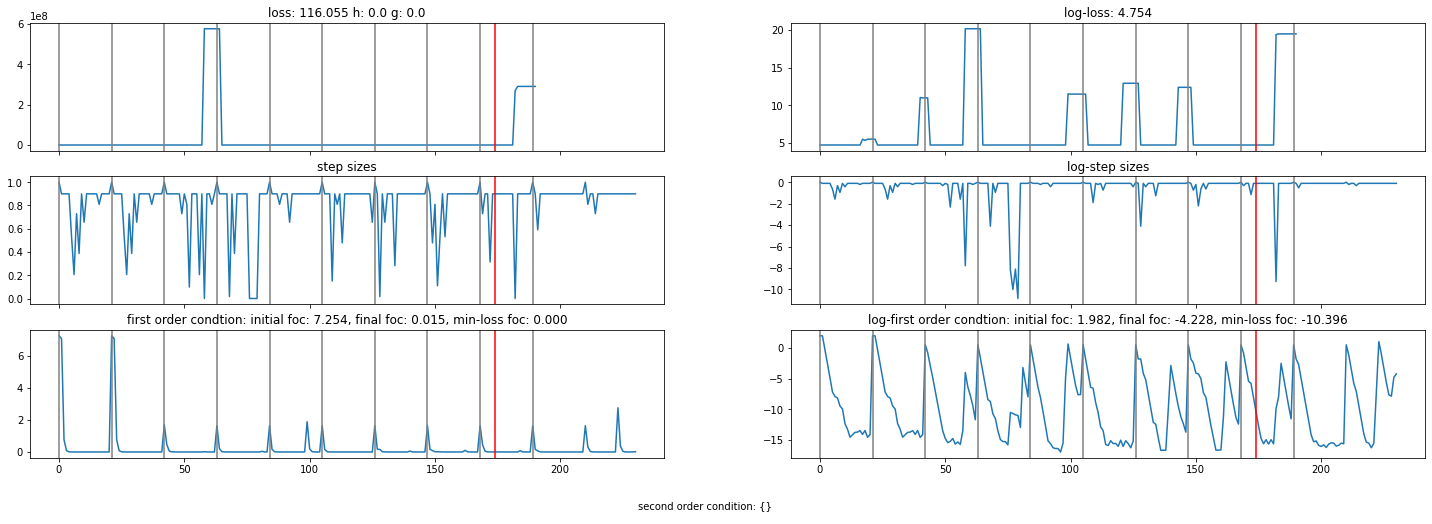

In [13]:
resgraph = utils.plot_results(result)

In [14]:
voxel_id, voxel_bound = voxel_cluster(X_k, np.array([5, 5]))

<AxesSubplot:>

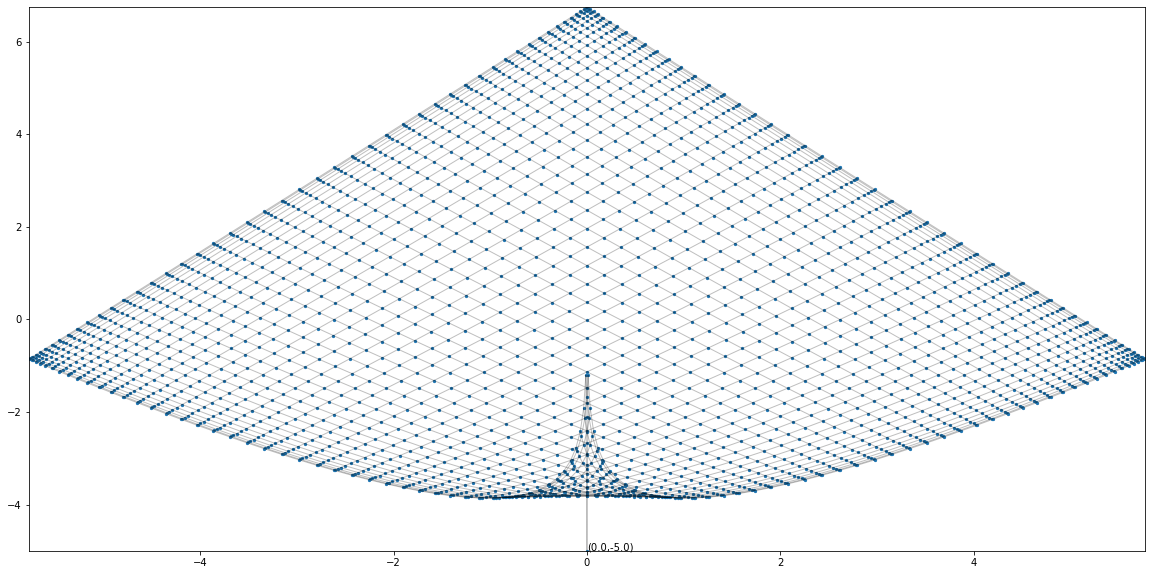

In [15]:
utils.plot_graph(result['projxinit'], graph, title='', fixed_indices=fixed_indices, c=None)

<AxesSubplot:title={'center':'loss: 116.05 h: 0.01 g: 0.0 foc: 0.0'}>

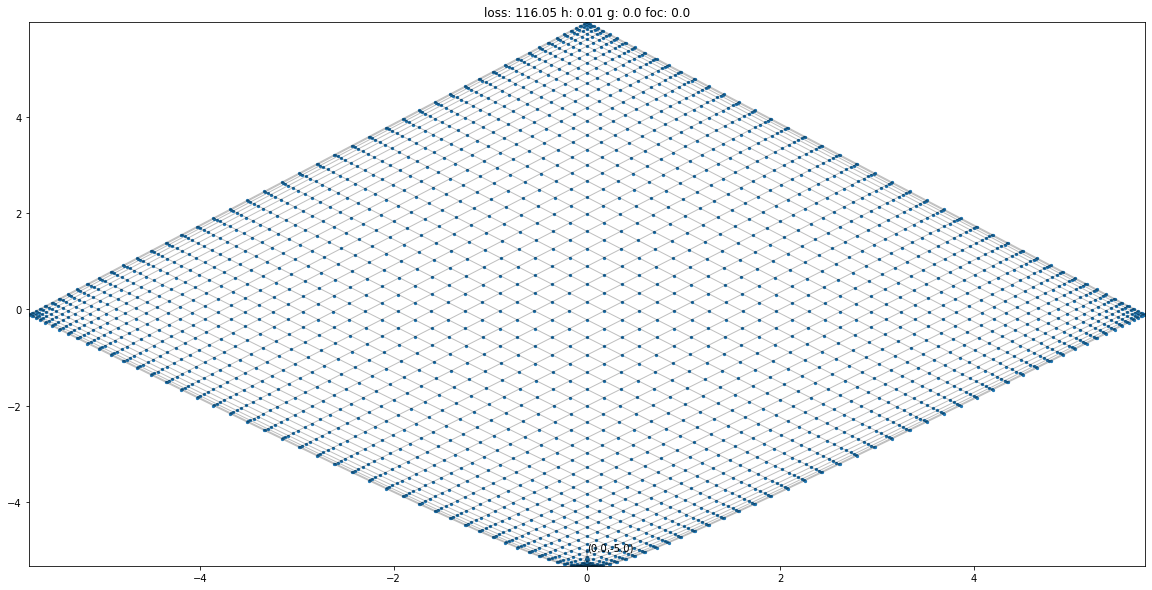

In [16]:
#result['h'] = 0.0
#result['g'] = 0.0
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(np.min(result['lossh']),2)), 
                                                                            np.round(result['h'][-1],2), np.round(result['g'][-1],2), 
                                                                           str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=None)

In [17]:
import jax.numpy as jnp
a = np.random.rand(3,3)
b = np.random.rand(3,3)

jnp.add(a,b)

DeviceArray([[0.87765265, 0.56529534, 1.679005  ],
             [1.0909737 , 0.63181275, 1.514179  ],
             [0.9222769 , 0.9587342 , 0.53888154]], dtype=float32)

In [18]:
vectorize = jax.vmap(jnp.add, in_axes=(0,1), out_axes=1)
vectorize(a,b)

DeviceArray([[0.87765265, 0.67628264, 1.4330114 ],
             [0.9799864 , 0.63181275, 1.7864766 ],
             [1.1682705 , 0.6864367 , 0.53888154]], dtype=float32)

In [19]:
a = np.array(['a', 'b', 'a', 'a', 'b', 'a'])
b = np.array([150, 154, 147, 126, 148, 125])
c = np.zeros_like(b)
c[0] = 150
np.where(a == "b", np.roll(c, 1), b)

array([150, 150, 147, 126,   0, 125])